# Loan Prediction 

Using insurance data to predict whether or not a loan will get approved using Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA)

Data set is provided by Analytics Vidhya as part of their Loan Prediction Practice Problem competition here:
https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/



## Import packages and data

Import initial packages and data into a pandas dataframe

This data set already comes pre-sorted into training and test sets. Each set will be imported into its own Pandas data frame

In [1]:
import numpy as np
import pandas as pd

""" Import data """
df_train = pd.read_csv("../LoanPrediction/train.csv")
df_test = pd.read_csv("../LoanPrediction/test.csv")

## Data Exploration

Brief analysis of the data set to assess what needs to be addressed later in data munging

(Steps loosely follow those in the Analytics Vidhya tutorial found here:
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-learn-data-science-python-scratch-2/ )

In [2]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


#### Some things of note from this quick analysis:
* There should be a total of 614 entries
* LoanAmount has 22 missing values (592 out of 614)
* Loan_Amount_Term has 14 missing values (600 out of 614)
* Credit_History has 50 missing values (564 out of 614)
* ApplicantIncome, CoapplicantIncome, and LoanAmount have maximum values that are at least several standard deviations larger than the mean, suggesting possible outliers skewing the data

The non-numerical categories (such as Property_Area can be explored using a frequency count to check of obvious outliers

In [4]:
df_train['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [5]:
df_train['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [6]:
df_train['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [7]:
df_train['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [8]:
df_train['Education'].value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [9]:
df_train['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

ApplicantIncome can be visualized using a histogram and a boxplot to help identify outliers

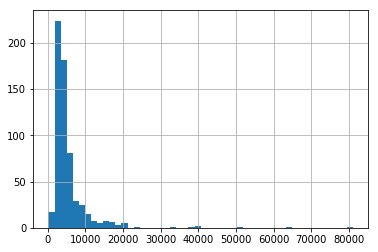

In [10]:
from IPython.display import Image
%matplotlib inline

df_train['ApplicantIncome'].hist(bins=50)

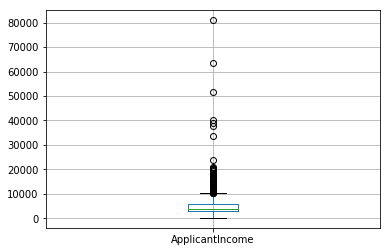

In [11]:
df_train.boxplot(column='ApplicantIncome')

From these two plots, it is evident that there are outliers of very large values skewing the data.

## Data Munging

Based on the analysis done during the data exploration steps, there are missing values and outliers in the data that need to be addressed

### Check for missing values and replace them

The algorithms don't work when missing values are present in the data, so null or missing values need to be addressed

In [12]:
df_train.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

The previous histogram of LoanAmount showed outliers at very large values. This effect may be nullified using a log scale

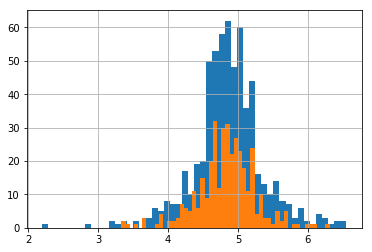

In [15]:
df_train['LoanAmount'].fillna(df_train['LoanAmount'].mean(), inplace=True)
df_train['LoanAmount_log'] = np.log(df_train['LoanAmount'])
df_train['LoanAmount_log'].hist(bins=50)

df_test['LoanAmount'].fillna(df_train['LoanAmount'].mean(), inplace=True)
df_test['LoanAmount_log'] = np.log(df_test['LoanAmount'])
df_test['LoanAmount_log'].hist(bins=50)

This distribution looks closer to a normal distribution and no longer has extreme outliers.

ApplicantIncome will be addressed next. Intuitively, one could have a low ApplicantIncome but a high CoapplicantIncome. Thus it makes sense to combine the two features into a TotalIncome category and apply a similar log transformation

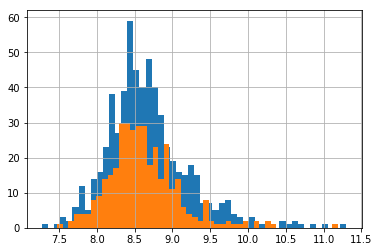

In [16]:
df_train['TotalIncome'] = df_train['ApplicantIncome'] + df_train['CoapplicantIncome']
df_train['TotalIncome_log'] = np.log(df_train['TotalIncome'])
df_train['TotalIncome_log'].hist(bins=50) 

df_test['TotalIncome'] = df_test['ApplicantIncome'] + df_test['CoapplicantIncome']
df_test['TotalIncome_log'] = np.log(df_test['TotalIncome'])
df_test['TotalIncome_log'].hist(bins=50) 

This distribution now looks more normal and lacks extreme outliers as well.

For the remaining categories, all missing values will be filled in using the the most frequent value in that category.

In [17]:
df_train['Gender'].fillna(df_train['Gender'].mode()[0], inplace=True)
df_train['Married'].fillna(df_train['Married'].mode()[0], inplace=True)
df_train['Dependents'].fillna(df_train['Dependents'].mode()[0], inplace=True)
df_train['Loan_Amount_Term'].fillna(df_train['Loan_Amount_Term'].mode()[0], inplace=True)
df_train['Credit_History'].fillna(df_train['Credit_History'].mode()[0], inplace=True)
df_train['Self_Employed'].fillna('No',inplace=True)

df_test['Gender'].fillna(df_test['Gender'].mode()[0], inplace=True)
df_test['Married'].fillna(df_test['Married'].mode()[0], inplace=True)
df_test['Dependents'].fillna(df_test['Dependents'].mode()[0], inplace=True)
df_test['Loan_Amount_Term'].fillna(df_test['Loan_Amount_Term'].mode()[0], inplace=True)
df_test['Credit_History'].fillna(df_test['Credit_History'].mode()[0], inplace=True)
df_test['Self_Employed'].fillna('No',inplace=True)

SKLearn models need inputs to be numeric, so all categorical variables will be converted into numeric by encoding the categories

In [18]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df_train[i] = le.fit_transform(df_train[i])
df_train.dtypes 

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

All transformations done on the training set need to be applied to the test set as well

In [19]:
var_mod2 = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
le2 = LabelEncoder()
for j in var_mod2:
    df_test[j] = le2.fit_transform(df_test[j])
df_test.dtypes 

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
LoanAmount_log       float64
TotalIncome            int64
TotalIncome_log      float64
dtype: object

## Identify features and target

Features and target are identified. Data is then standardized for the fitting algorigms


In [20]:
features = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History", "Property_Area"]
target = ["Loan_Status"]

X_train = df_train[features].values
y_train = df_train[target].values

X_test = df_test[features].values

""" Standardize data """
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)